In [10]:
# 각 알고리즘 별 oof를 수집하여 Ridge를 이용하여 weight를 추출
# Voting model을 구성하여 위에서 구한 weight기반하여 결과 추출

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [13]:
data_path='../../data/'

In [14]:
ambrosm_oof_df = pd.read_csv(data_path+'oof/ambrosm.csv')
lightgbm_oof_df = pd.read_csv(data_path+'oof/lightgbm.csv')
xgboost_oof_df = pd.read_csv(data_path+'oof/xgboost.csv')

In [15]:
train_df = pd.read_csv(data_path + 'train.csv', index_col='id')
test_df = pd.read_csv(data_path + 'test.csv', index_col='id')
# train = pd.read_csv(data_path + 'train_f5.csv', index_col='id')
# test = pd.read_csv(data_path + 'test_f5.csv', index_col='id')
# train_vif20 = pd.read_csv(data_path + 'train_vif20.csv', index_col='id')
# test_vif20 = pd.read_csv(data_path + 'test_vif20.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

In [16]:
X = train_df.drop(columns=['defects'])
y = train_df.defects
X_origin_train, X_origin_val, y_origin_train, y_origin_val = train_test_split(X, y, test_size=0.2, random_state=61, stratify=y)

In [17]:
models = {
    'xgboost': XGBClassifier(
        max_depth=5,
        colsample_bynode=0.5195981912942003,
        reg_lambda=2.0596502472632006,
        n_estimators=1345,
        learning_rate=0.010119804013091233,
        random_state=61,
        tree_method='hist',
        enable_categorical=True,
    ),
    'lightgbm': LGBMClassifier(
        max_depth=22,
        num_leaves=128,
        min_child_samples=46,
        colsample_bytree=0.5924502637788397,
        n_estimators=659,
        learning_rate=0.008200284931836449,
        random_state=61,
    ),
    'rf':RandomForestClassifier(min_samples_leaf=190, max_features=1.0, random_state=61),
    'hgb':HistGradientBoostingClassifier(random_state=61),
    'logistic_nystroem': make_pipeline(
        FunctionTransformer(np.log1p),
        Nystroem(n_components=400, random_state=61),
        StandardScaler(),
        LogisticRegression(dual=False, C=0.0042, max_iter=1500, random_state=61)
    ),
    'extra': make_pipeline(
        FunctionTransformer(np.log1p),
        ExtraTreesClassifier(
            n_estimators=100,
            min_samples_leaf=130,
            max_features=1.0,
            random_state=61
        ),
    ),

}

In [18]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# Make KFold OOF prediction
K=10
def oof_preds(best_model, model_name=None):
    if model_name:
        print(f"{model_name}'s oof prediction")

    # make KFold
    folds = StratifiedKFold(n_splits=K, random_state=61, shuffle=True)
    final_preds = []
    losses = []
    # fitting with best_model
    # X = train_df.drop(columns='defects')
    # y = train_df['defects']

    oof = np.full(len(X), np.nan)
    for i, (train_idx, val_idx) in enumerate(folds.split(X_origin_train, y_origin_train)):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        print(f"========== Fold {i+1} ==========")
        best_model.fit(X_train, y_train)
        preds = best_model.predict_proba(X_val)[:, 1]
        oof[val_idx] = preds
        test_preds = best_model.predict_proba(test_df)[:, 1]
        final_preds.append(test_preds)
        loss = roc_auc_score(y_val, preds)

        losses.append(loss)

    avg_loss = np.mean(losses)
    print(f"Loss : {avg_loss:.4f}")
    return final_preds, oof, avg_loss

In [19]:
model_scores = [(model_name, oof_preds(model, model_name)[2]) for model_name, model in models.items()]

xgboost's oof prediction
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fold 9 ==========
========== Fold 10 ==========
Loss : 0.7936
lightgbm's oof prediction
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fold 9 ==========
========== Fold 10 ==========
Loss : 0.7926
rf's oof prediction
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fold 9 ==========
========== Fold 10 ==========
Loss : 0.7921
hgb's oof pred

In [20]:
model_scores.sort(key=lambda m: m[1], reverse=True)
model_scores

[('xgboost', 0.7935995059519462),
 ('lightgbm', 0.7926080723099801),
 ('extra', 0.7921566281931738),
 ('rf', 0.7920955584985394),
 ('logistic_nystroem', 0.7920636134131127),
 ('hgb', 0.7919931855932343)]

In [52]:
from sklearn.ensemble import VotingClassifier
def run_k_fold(models, model_scores, num=6, weight='auto'):
    start = 2
    if weight=='auto':
        weights = [6,5,4,3,2,1]
    elif weight=='balance':
        weights = [1]*num
    else:
        weights = [6,5,4,3,2,1]
    print(f'{weight}!!', weights)
    best_score = 0
    best_model_num = 0
    for model_num in range(start, start+num-1):
        chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(model_num)]
        chosen_model_names = [model_scores[m_idx][0] for m_idx in range(model_num)]
        print(f'chosen models : {chosen_model_names}')
        voter_model = VotingClassifier(chosen_models, weights = weights[:model_num], voting = 'soft')
        preds, oof, oof_score = oof_preds(voter_model)
        preds = np.mean(preds, axis=0)
        if model_num==2 or best_score<oof_score:
            best_preds = preds
            best_score = oof_score
            best_model_num = model_num
    print(f'best model 개수 : {best_model_num}, best oof score : {best_score}')
    return best_model_num, best_score, best_preds

In [53]:
k,best_score_auto,best_preds_auto = run_k_fold(models, model_scores, num=6, weight='balance')

balance!! [1, 1, 1, 1, 1, 1]
chosen models : ['xgboost', 'lightgbm']
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fold 9 ==========
========== Fold 10 ==========
Loss : 0.7936
chosen models : ['xgboost', 'lightgbm', 'extra']
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fold 9 ==========
========== Fold 10 ==========
Loss : 0.7937
chosen models : ['xgboost', 'lightgbm', 'extra', 'rf']
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fol

In [23]:
# k,best_score_auto,best_preds_auto = run_k_fold(models, model_scores, num=6, weight='auto')

chosen models : ['xgboost', 'lightgbm']
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fold 9 ==========
========== Fold 10 ==========
Loss : 0.7936
chosen models : ['xgboost', 'lightgbm', 'extra']
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fold 9 ==========
========== Fold 10 ==========
Loss : 0.7937
chosen models : ['xgboost', 'lightgbm', 'extra', 'rf']
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fol

In [59]:
chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(k)]
chosen_model_names = [model_scores[m_idx][0] for m_idx in range(k)]
print(f'chosen models : {chosen_model_names}')
voter_model = VotingClassifier(chosen_models, weights = [1 for idx in range(k)], voting = 'soft')
preds, oof, oof_score = oof_preds(voter_model)
val_preds_proba = voter_model.predict_proba(X_origin_val)[:, 1]
val_preds = voter_model.predict(X_origin_val)

chosen models : ['xgboost', 'lightgbm', 'extra', 'rf', 'logistic_nystroem']
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
========== Fold 6 ==========
========== Fold 7 ==========
========== Fold 8 ==========
========== Fold 9 ==========
========== Fold 10 ==========
Loss : 0.7939


In [60]:
from sklearn.metrics import accuracy_score, f1_score

val_score = roc_auc_score(y_origin_val, val_preds_proba)

print("Validation auc roc : %.4f" % val_score)
print("Validation acc : %.4f" % accuracy_score(y_origin_val, val_preds))
print("Validation f1_score : %.4f" % f1_score(y_origin_val, val_preds))

Validation auc roc : 0.8099
Validation acc : 0.8203
Validation f1_score : 0.5067


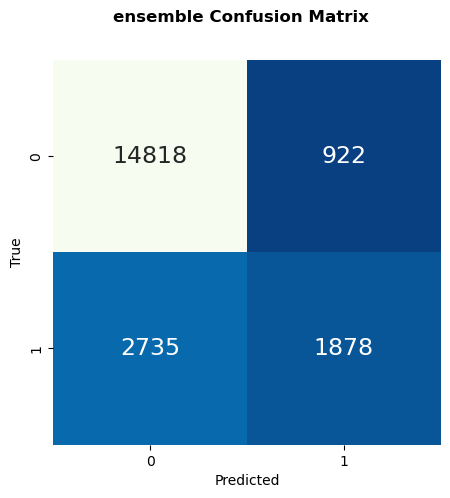

In [61]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title, model_name):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, cmap='GnBu_r', cbar=False, fmt='.0f', annot_kws={"size": 17})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.suptitle(title, fontsize=12, fontweight='bold')
    plt.savefig(f'{model_name}_baseline.png')
    plt.show()

cm=confusion_matrix(y_origin_val, np.greater_equal(val_preds, 0.5).astype(int))
plot_confusion_matrix(cm, 'ensemble Confusion Matrix', 'ensemble')

In [62]:
submission['defects'] = voter_model.predict_proba(test_df)[:, 1]

In [63]:
submission.to_csv(data_path+'submission/ensemble_selected_final_balance.csv')

<Axes: xlabel='id'>

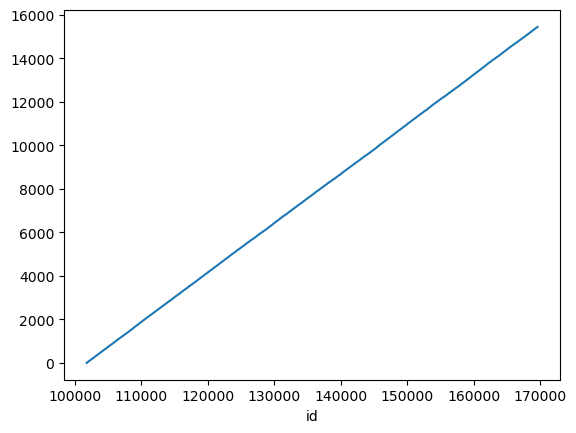

In [64]:
submission['defects'].cumsum().plot()